In [2]:
import os
import datetime
import sys
import time
import requests
from datetime import datetime, timedelta
import json
import numpy as np
from sentence_transformers import SentenceTransformer
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import r2_score
import nltk
from nltk.tokenize import sent_tokenize
import matplotlib.pyplot as plt
import tqdm

I0522 13:15:23.945393 14900 file_utils.py:41] PyTorch version 1.1.0 available.


In [2]:
EARLIEST_DATE = datetime(2019, 12, 19)

In [3]:
model = SentenceTransformer('bert-large-nli-mean-tokens')

I0518 18:38:28.925414 14728 SentenceTransformer.py:29] Load pretrained SentenceTransformer: bert-large-nli-mean-tokens
I0518 18:38:28.928401 14728 SentenceTransformer.py:32] Did not find a '/' or '\' in the name. Assume to download model from server.
I0518 18:38:28.934390 14728 SentenceTransformer.py:67] Load SentenceTransformer from folder: C:\Users\Jai/.cache\torch\sentence_transformers\public.ukp.informatik.tu-darmstadt.de_reimers_sentence-transformers_v0.2_bert-large-nli-mean-tokens.zip
I0518 18:38:28.990296 14728 configuration_utils.py:281] loading configuration file C:\Users\Jai/.cache\torch\sentence_transformers\public.ukp.informatik.tu-darmstadt.de_reimers_sentence-transformers_v0.2_bert-large-nli-mean-tokens.zip\0_BERT\config.json
I0518 18:38:28.992303 14728 configuration_utils.py:319] Model config BertConfig {
  "_num_labels": 2,
  "architectures": null,
  "attention_probs_dropout_prob": 0.1,
  "bad_words_ids": null,
  "bos_token_id": null,
  "decoder_start_token_id": null,
 

In [5]:
model.device.type

'cpu'

In [6]:
def fit_beta_reg(y, X):
    binom_glm = sm.GLM(y, X, family=sm.families.Binomial())
    binom_results = binom_glm.fit()
    return binom_results
# plt.plot(y, binom_results.predict(X), 'o', alpha=0.2);

In [7]:
def goodness_of_fit(model, true, X):
    y_predicted = model.get_prediction(X)
    pred_vals = y_predicted.summary_frame()['mean']
    print(r2_score(true, pred_vals))

In [8]:
def sentence_tokenize(text):
    return sent_tokenize(text)

In [9]:
def none_or_empty(text):
    return text is None or len(text) == 0 or text == "[removed]" or text == '[deleted]'

In [10]:
def get_dates(latest_date):
    # Get all week increments from earliest date until present
    dates = []
    epochs = []
    curr = EARLIEST_DATE
    while curr < latest_date:
        dates.append(curr.strftime("%m/%d/%Y"))
        epochs.append(int(curr.timestamp()))
        curr += timedelta(weeks=1)
    dates.append(latest_date.strftime("%m/%d/%Y"))
    epochs.append(int(latest_date.timestamp()))
    return dates, epochs

In [11]:
def get_week_score(dirname, week_file):
    # Get data stored for subreddit
    
    data = get_file_data(dirname, week_file)
    all_means = np.array([])
    def get_post_score(text):
#         sen_split = sentence_tokenize(text)
        encoded_sen = model.encode(text)
        valence_pred_results = valence_model.get_prediction(encoded_sen)
        valence_pred_means = valence_pred_results.predicted_mean
        arousal_pred_results = arousal_model.get_prediction(encoded_sen)
        arousal_pred_means = arousal_pred_results.predicted_mean
        dominance_pred_results = dominance_model.get_prediction(encoded_sen)
        dominance_pred_means = dominance_pred_results.predicted_mean
        return valence_pred_means, arousal_pred_means, dominance_pred_means
    
    valid_text = []
    for element in data:
        valid_text.extend(sentence_tokenize(element))
    v_scores, a_scores, d_scores = get_post_score(valid_text)
    print(len(valid_text) == len(v_scores) == len(a_scores) == len(d_scores))
    return np.mean(v_scores), np.mean(a_scores), np.mean(d_scores), np.std(v_scores), np.std(a_scores), np.std(d_scores)
#         try:
#             text = element['body']
#         except KeyError:
#             text = element['selftext'] if not none_or_empty(element['selftext']) else element['title']
#         valid_text.extend(sentence_tokenize(text))
# #     print(len(valid_text))
#     scores = get_post_score(valid_text)
# #     print(len(scores))
#     return np.mean(scores), np.std(scores) 
        

In [12]:
5==5==5==5

True

# SETUP AND TEST

In [13]:
df_vad = pd.read_csv('Vad Lexicon/lexicon.txt', delimiter='\t', header = 0)
df_vad = df_vad.dropna()
df_vad.index = df_vad['Word']
df_vad = df_vad[['Valence', 'Arousal', 'Dominance']]

In [14]:
vad_words = list(df_vad.index)
vad_embeddings = model.encode(vad_words)


Batches: 100%|██████████| 2501/2501 [16:33<00:00,  1.81it/s]


In [15]:
vad_embeddings = np.array(vad_embeddings)

In [17]:
import pickle
with open("vad_embeddings.pkl", "wb") as file:
    pickle.dump(vad_embeddings, file)

In [25]:
model.encode(["Elle", "elle"])

Batches: 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


[array([-0.9000952,  0.2918339,  0.6838582, ...,  0.5866274, -0.2211324,
        -0.5820856], dtype=float32),
 array([-0.9000952,  0.2918339,  0.6838582, ...,  0.5866274, -0.2211324,
        -0.5820856], dtype=float32)]

In [22]:
new_vad = pickle.load(open('vad_embeddings.pkl', 'rb'))
print(len(new_vad))
print(len(vad_words))
print(type(new_vad))
print(new_vad[:10])

20006
20006
<class 'numpy.ndarray'>
[[-0.37462655  0.33860603  0.5137679  ...  0.45254824 -0.43836
  -0.52928245]
 [-0.3044096   0.18774791  0.36055964 ...  0.33500975 -0.41713622
  -0.53494424]
 [ 0.00274566  0.27722648  0.21254194 ...  0.15628038 -0.09462776
  -0.9267065 ]
 ...
 [-0.17078774 -0.38655353  0.48484167 ...  0.33273053 -1.0295545
  -0.6479943 ]
 [-0.11109585 -0.56099325  0.6403473  ...  0.20488143 -1.0351025
  -0.7852743 ]
 [ 0.12990841 -0.4716695   0.7150068  ...  0.12895401 -1.1734991
  -0.7761264 ]]


In [13]:
valence = np.array(df_vad['Valence'].tolist())
arousal  = np.array(df_vad['Arousal'].tolist())
dominance = np.array(df_vad['Dominance'].tolist())

In [39]:
titles = ['valence', 'arousal', 'dominance']
dims = [valence, arousal, dominance]
# for i in range(len(titles)):
#     reg_model = fit_beta_reg(dims[i], vad_embeddings)
#     goodness_of_fit(reg_model, dims[i], vad_embeddings)
    
valence_model = fit_beta_reg(valence, vad_embeddings)
goodness_of_fit(valence_model, valence, vad_embeddings)
arousal_model = fit_beta_reg(arousal, vad_embeddings)
goodness_of_fit(arousal_model, arousal, vad_embeddings)
dominance_model = fit_beta_reg(dominance, vad_embeddings)
goodness_of_fit(dominance_model, dominance, vad_embeddings)

0.719292563382529
0.6015808128609319
0.6420082478782179


In [46]:
# DIRNAME = 'state_analysis/'
def get_file_data(dirname, file_name):
    with open(f'{dirname}{file_name}', 'r', encoding="UTF-8") as file:
        data = file.readlines()
        return [line.strip() for line in data] 


In [28]:
def sort_files(dirname, cutoff=1):
    sort_map = {}
    max_int = cutoff
    for file in os.listdir(dirname):
        dot_index = file.index(".")
        week = int(file[4:dot_index])
        if week >= cutoff:
            if sort_map.get(week) is None:
                sort_map[week] = [file]
            else:
                sort_map[week].append(file)
        if week >= max_int:
            max_int = week
    sorted_files = []
    for i in range(cutoff, max_int+1):
        sorted_files.extend(sort_map[i])
    return sorted_files
        

In [32]:
for i in range(1, 2):
    print(f"Region {i}")
    dirname = f"Region{i}/"
    sorted_files = sort_files(dirname, cutoff=10)
    valence_means = []
    valence_stds = []
    arousal_means = []
    arousal_stds = []
    dominance_means = []
    dominance_stds = [] 
    for file in tqdm.tqdm(sorted_files):
#         print(file)
#         y = [x for x in range(1000000)]
        vmean, amean, dmean, vstd, astd, dstd = get_week_score(dirname, file)
        valence_means.append(vmean)
        valence_stds.append(vstd)
        arousal_means.append(amean)
        arousal_stds.append(astd)
        dominance_means.append(dmean)
        dominance_stds.append(dstd)
    
        

Region 1


  0%|          | 0/65 [00:00<?, ?it/s]

Week10.Midwest.txt
Week10.Mountain Plains.txt


  3%|▎         | 2/65 [00:00<00:05, 11.66it/s]

Week10.Northeast.txt
Week10.Southeast.txt


  6%|▌         | 4/65 [00:00<00:05, 12.19it/s]

Week10.West Coast.txt
Week11.Midwest.txt


  9%|▉         | 6/65 [00:00<00:04, 12.73it/s]

Week11.Mountain Plains.txt
Week11.Northeast.txt


 12%|█▏        | 8/65 [00:00<00:04, 13.12it/s]

Week11.Southeast.txt
Week11.West Coast.txt


 15%|█▌        | 10/65 [00:00<00:04, 13.34it/s]

Week12.Midwest.txt
Week12.Mountain Plains.txt


 18%|█▊        | 12/65 [00:00<00:03, 13.63it/s]

Week12.Northeast.txt
Week12.Southeast.txt


 22%|██▏       | 14/65 [00:01<00:03, 13.86it/s]

Week12.West Coast.txt
Week13.Midwest.txt


 25%|██▍       | 16/65 [00:01<00:03, 13.52it/s]

Week13.Mountain Plains.txt
Week13.Northeast.txt


 28%|██▊       | 18/65 [00:01<00:03, 13.53it/s]

Week13.Southeast.txt
Week13.West Coast.txt


 31%|███       | 20/65 [00:01<00:03, 13.67it/s]

Week14.Midwest.txt
Week14.Mountain Plains.txt


 34%|███▍      | 22/65 [00:01<00:03, 13.34it/s]

Week14.Northeast.txt
Week14.Southeast.txt


 37%|███▋      | 24/65 [00:01<00:03, 13.07it/s]

Week14.West Coast.txt
Week15.Midwest.txt


 40%|████      | 26/65 [00:01<00:02, 13.28it/s]

Week15.Mountain Plains.txt
Week15.Northeast.txt


 43%|████▎     | 28/65 [00:02<00:02, 13.66it/s]

Week15.Southeast.txt
Week15.West Coast.txt


 46%|████▌     | 30/65 [00:02<00:02, 13.32it/s]

Week16.Midwest.txt
Week16.Mountain Plains.txt


 49%|████▉     | 32/65 [00:02<00:02, 13.55it/s]

Week16.Northeast.txt
Week16.Southeast.txt


 52%|█████▏    | 34/65 [00:02<00:02, 13.47it/s]

Week16.West Coast.txt
Week17.Midwest.txt


 55%|█████▌    | 36/65 [00:02<00:02, 13.63it/s]

Week17.Mountain Plains.txt
Week17.Northeast.txt


 58%|█████▊    | 38/65 [00:02<00:01, 13.72it/s]

Week17.Southeast.txt
Week17.West Coast.txt


 62%|██████▏   | 40/65 [00:02<00:01, 13.98it/s]

Week18.Midwest.txt
Week18.Mountain Plains.txt


 65%|██████▍   | 42/65 [00:03<00:01, 14.20it/s]

Week18.Northeast.txt
Week18.Southeast.txt


 68%|██████▊   | 44/65 [00:03<00:01, 14.10it/s]

Week18.West Coast.txt
Week19.Midwest.txt


 71%|███████   | 46/65 [00:03<00:01, 14.20it/s]

Week19.Mountain Plains.txt
Week19.Northeast.txt


 74%|███████▍  | 48/65 [00:03<00:01, 14.05it/s]

Week19.Southeast.txt
Week19.West Coast.txt


 77%|███████▋  | 50/65 [00:03<00:01, 14.19it/s]

Week20.Midwest.txt
Week20.Mountain Plains.txt


 80%|████████  | 52/65 [00:03<00:00, 14.40it/s]

Week20.Northeast.txt
Week20.Southeast.txt


 83%|████████▎ | 54/65 [00:03<00:00, 14.67it/s]

Week20.West Coast.txt
Week21.Midwest.txt


 86%|████████▌ | 56/65 [00:04<00:00, 14.63it/s]

Week21.Mountain Plains.txt
Week21.Northeast.txt


 89%|████████▉ | 58/65 [00:04<00:00, 14.02it/s]

Week21.Southeast.txt
Week21.West Coast.txt


 92%|█████████▏| 60/65 [00:04<00:00, 14.02it/s]

Week22.Midwest.txt
Week22.Mountain Plains.txt


 95%|█████████▌| 62/65 [00:04<00:00, 14.20it/s]

Week22.Northeast.txt
Week22.Southeast.txt


 98%|█████████▊| 64/65 [00:04<00:00, 14.45it/s]

Week22.West Coast.txt


100%|██████████| 65/65 [00:04<00:00, 13.88it/s]


In [35]:
x = {1: ["Mid", "Pacific", "North", "Alabama"]}
print(x)
x[1].sort()
x

{1: ['Mid', 'Pacific', 'North', 'Alabama']}


{1: ['Alabama', 'Mid', 'North', 'Pacific']}

In [27]:
dates, epochs = get_dates(datetime.datetime.utcnow())
# diachronic = np.bincount(np.digitize(state_json, epochs))
# d_vals = ','.join(map(str, map(int, diachronic[1:])))
# dia_file.write(f"{state},{d_vals}\n")

(['12/19/2019',
  '12/26/2019',
  '01/02/2020',
  '01/09/2020',
  '01/16/2020',
  '01/23/2020',
  '01/30/2020',
  '02/06/2020',
  '02/13/2020',
  '02/20/2020',
  '02/27/2020',
  '03/05/2020',
  '03/12/2020',
  '03/19/2020',
  '03/26/2020',
  '04/02/2020',
  '04/09/2020',
  '04/16/2020',
  '04/23/2020',
  '04/30/2020',
  '05/07/2020',
  '05/12/2020'],
 [1576731600,
  1577336400,
  1577941200,
  1578546000,
  1579150800,
  1579755600,
  1580360400,
  1580965200,
  1581570000,
  1582174800,
  1582779600,
  1583384400,
  1583985600,
  1584590400,
  1585195200,
  1585800000,
  1586404800,
  1587009600,
  1587614400,
  1588219200,
  1588824000,
  1589310269])

In [26]:
from sentence_transformers.SentenceTransformer import torch

In [ ]:
with open("emotion_data_10_12.json", "r") as file:
    data = file.readlines()
    em_data1 = json.loads(data[0])
with open("emotion_data_13_15.json", "r") as file:
    data = file.readlines()
    em_data2 = json.loads(data[0])
with open("emotion_data_16_22.json", "r") as file:
    data = file.readlines()
    em_data3 = json.loads(data[0])
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
# fig.figsize = (30, 30)
# print(fig.figsize)
for fignum, key in enumerate(['valence', 'arousal', "dominance"]):
    means = np.array(em_data1[f'{key}_means']) #.reshape(-1, 5).
    means = np.append(means, np.array(em_data2[f'{key}_means']))
    means = np.append(means, np.array(em_data3[f'{key}_means']))
    means = means.reshape(-1, 5).T
    stds = np.array(em_data1[f'{key}_stds']) #.reshape(-1, 5).
    stds = np.append(stds, np.array(em_data2[f'{key}_stds']))
    stds = np.append(stds, np.array(em_data3[f'{key}_stds']))
    stds = means.reshape(-1, 5).T
    # plt.scatter([i for i in range(5)], vmeans)
#     print(vmeans)
    regions = ['midwest', 'mountain range', 'northeast', 'southeast', 'west coast']

    for i in range(len(means)):
        ax[fignum].plot([j for j in range(means.shape[1])], means[i], label=regions[i])
    ax[fignum].set_ylabel(f'{key.capitalize()} Score')
    if fignum == 0:
        ax[fignum].legend()
#         plt.errorbar([j for j in range(means.shape[1])], means[i], stds[i], linestyle='-', marker='^')
# fig.legend(loc='upper left')
fig.suptitle('Region 1 Mapping')
fig.tight_layout()
#     plt.savefig(f"region_1_{key}.png")
# plt.show()
plt.savefig('test.png')
    # plt.legend(loc="lower left")

Region1.arousal.png


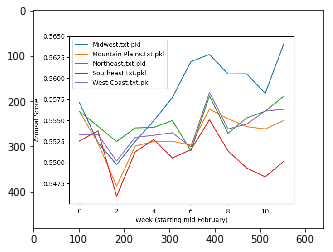

Region1.dominance.png


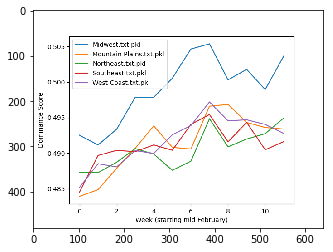

Region1.valence.png


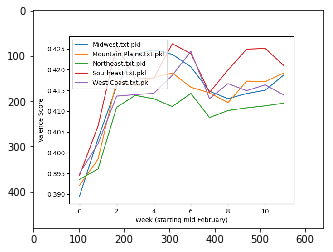

Region2.arousal.png


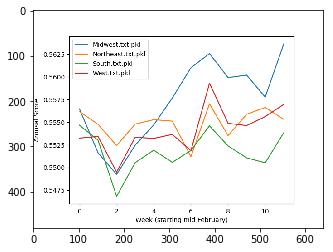

Region2.dominance.png


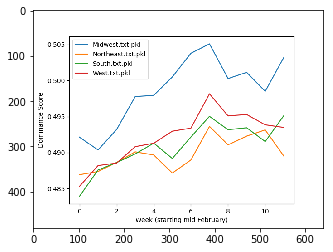

Region2.valence.png


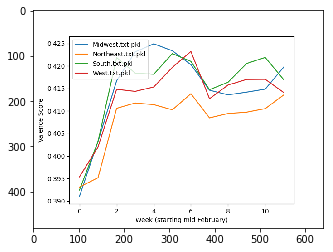

Region3.arousal.png


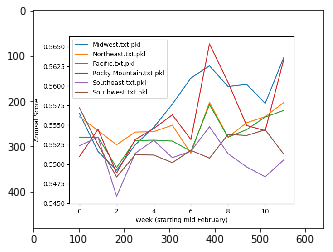

Region3.dominance.png


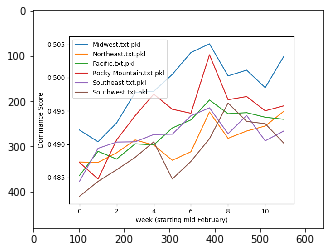

Region3.valence.png


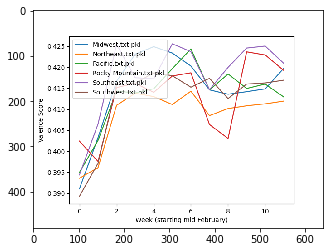

Region4.arousal.png


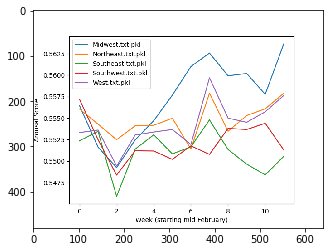

Region4.dominance.png


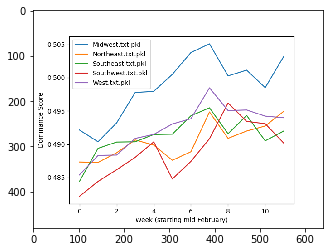

Region4.valence.png


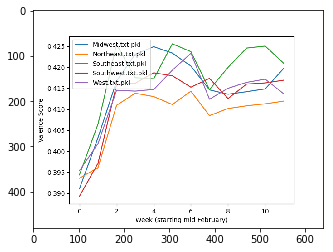

Voting.arousal.png


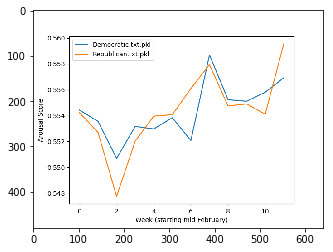

Voting.dominance.png


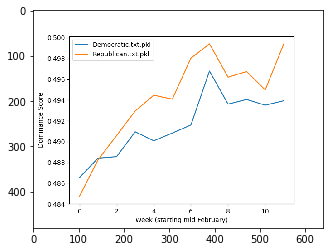

Voting.valence.png


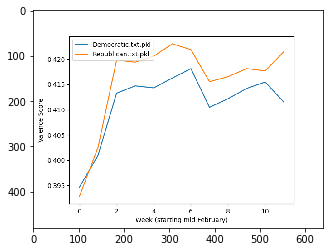

In [6]:
for file in os.listdir('plots/plots/'):
    print(file)
    plt.imshow(plt.imread('plots/plots/'+ file))
    plt.show()